# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic.

In [33]:
# Load pcap file directly into pandas DataFrame
from scapy.all import rdpcap, IP, TCP, UDP, DNS
import pandas as pd

# Load the pcap file
packets = rdpcap('netflix.pcap')
print(f"Total packets: {len(packets)}")

# Create DataFrame directly using list comprehension
rows = []
for p in packets:
    is_dns = DNS in p
    proto = "DNS" if is_dns else ("TCP" if TCP in p else ("UDP" if UDP in p else p.name))
    txid = p[DNS].id if is_dns else None
    rows.append({
        "timestamp": float(getattr(p, "time", None)),
        "length": len(p),
        "src_ip": p[IP].src if IP in p else None,
        "dst_ip": p[IP].dst if IP in p else None,
        "protocol": proto,
        "src_port": p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None),
        "dst_port": p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None),
        "txid": txid,
        "info": str(p.summary())
    })

pcap_import = pd.DataFrame(rows)

print(f"\nDataFrame created with shape: {pcap_import.shape}")
print(f"Columns: {list(pcap_import.columns)}")

# Display first few rows
pcap_import.head()

Total packets: 141471

DataFrame created with shape: (141471, 9)
Columns: ['timestamp', 'length', 'src_ip', 'dst_ip', 'protocol', 'src_port', 'dst_port', 'txid', 'info']

DataFrame created with shape: (141471, 9)
Columns: ['timestamp', 'length', 'src_ip', 'dst_ip', 'protocol', 'src_port', 'dst_port', 'txid', 'info']


,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
0,1.518358e+09,77,192.168.43.72,128.93.77.234,DNS,55697.0,53.0,60684.0,Ether / IP / UDP / DNS Qry b'fonts.gstatic.com.'
1,1.518358e+09,77,192.168.43.72,128.93.77.234,DNS,59884.0,53.0,12314.0,Ether / IP / UDP / DNS Qry b'fonts.gstatic.com.'
2,1.518358e+09,87,192.168.43.72,128.93.77.234,DNS,61223.0,53.0,4563.0,Ether / IP / UDP / DNS Qry b'googleads.g.doubl...
3,1.518358e+09,87,192.168.43.72,128.93.77.234,DNS,58785.0,53.0,4740.0,Ether / IP / UDP / DNS Qry b'googleads.g.doubl...
4,1.518358e+09,78,192.168.43.72,128.93.77.234,DNS,51938.0,53.0,13362.0,Ether / IP / UDP / DNS Qry b'ytimg.l.google.com.'


### Identifying Netflix Traffic

Now let's filter for Netflix-specific traffic using multiple criteria:

In [20]:
# Identify Netflix Traffic from the packet data

print("=== IDENTIFYING NETFLIX TRAFFIC ===")

# first Analyze what traffic we have
print("1. Overall traffic summary:")
print(f"Total packets: {len(pcap_import):,}")
print(f"Protocol distribution:")
print(pcap_import['protocol'].value_counts())

# Second Look for Netflix-related DNS queries
print(f"\n2. Looking for Netflix DNS queries...")
netflix_dns = pcap_import[
    (pcap_import['protocol'] == 'DNS') & 
    (pcap_import['info'].str.contains('netflix', case=False, na=False))
]

print(f"Netflix DNS queries found: {len(netflix_dns)}")
if len(netflix_dns) > 0:
    print("Netflix domains queried:")
    for info in netflix_dns['info'].unique():
        print(f"  {info}")

# third Analyze top IP addresses (potential Netflix servers)
print(f"\n3. Top destination IPs (potential servers):")
top_dst_ips = pcap_import['dst_ip'].value_counts().head(10)
for ip, count in top_dst_ips.items():
    if ip and ip != '192.168.43.72':  # Exclude the client IP
        print(f"  {ip}: {count:,} packets")

print(f"\n4. Top source IPs (potential servers when receiving data):")
top_src_ips = pcap_import['src_ip'].value_counts().head(10)
for ip, count in top_src_ips.items():
    if ip and ip != '192.168.43.72':  # Exclude the client IP
        print(f"  {ip}: {count:,} packets")

# Step 4: Identify client and server IPs
client_ip = '192.168.43.72'  # This appears to be the client
potential_netflix_servers = ['198.38.120.166', '198.38.120.164']  # Top traffic IPs

print(f"\n5. Identified traffic pattern:")
print(f"Client IP: {client_ip}")
print(f"Potential Netflix servers: {potential_netflix_servers}")

# Step 5: Filter Netflix traffic
netflix_traffic = pcap_import[
    # Traffic FROM client TO Netflix servers (uploads/requests)
    ((pcap_import['src_ip'] == client_ip) & 
     (pcap_import['dst_ip'].isin(potential_netflix_servers))) |
    # Traffic FROM Netflix servers TO client (downloads/video data)
    ((pcap_import['src_ip'].isin(potential_netflix_servers)) & 
     (pcap_import['dst_ip'] == client_ip))
]

print(f"\n6. Netflix Traffic Results:")
print(f"Netflix packets: {len(netflix_traffic):,} out of {len(pcap_import):,} total")
print(f"Percentage: {len(netflix_traffic)/len(pcap_import)*100:.1f}%")

if len(netflix_traffic) > 0:
    print(f"\nNetflix traffic details:")
    print(f"Duration: {(netflix_traffic['timestamp'].max() - netflix_traffic['timestamp'].min())/60:.1f} minutes")
    print(f"Total data: {netflix_traffic['length'].sum()/1024/1024:.1f} MB")
    
    # Separate upstream vs downstream
    downstream = netflix_traffic[netflix_traffic['src_ip'].isin(potential_netflix_servers)]
    upstream = netflix_traffic[netflix_traffic['dst_ip'].isin(potential_netflix_servers)]
    
    print(f"\nTraffic direction:")
    print(f" Downstream (Netflix → Client): {len(downstream):,} packets ({downstream['length'].sum()/1024/1024:.1f} MB)")
    print(f" Upstream (Client → Netflix): {len(upstream):,} packets ({upstream['length'].sum()/1024/1024:.1f} MB)")

# Store the filtered Netflix traffic for next steps

print(f"\n Variable 'netflix_traffic' contains {len(netflix_traffic):,} Netflix-specific packets")

=== IDENTIFYING NETFLIX TRAFFIC ===
1. Overall traffic summary:
Total packets: 141,471
Protocol distribution:
protocol
TCP         141143
DNS            223
Ethernet        96
UDP              9
Name: count, dtype: int64

2. Looking for Netflix DNS queries...
Netflix DNS queries found: 7
Netflix domains queried:
  Ether / IP / UDP / DNS Qry b'www.netflix.com.'
  Ether / IP / UDP / DNS Qry b'customerevents.netflix.com.'
  Ether / IP / UDP / DNS Qry b'push.prod.netflix.com.'

3. Top destination IPs (potential servers):
  198.38.120.166: 47,902 packets
  198.38.120.164: 3,170 packets
  23.57.80.120: 834 packets
  52.19.39.146: 489 packets
  198.38.120.162: 266 packets
  172.217.18.195: 158 packets
  52.208.128.101: 102 packets
  198.38.120.137: 89 packets
  198.38.120.153: 75 packets

4. Top source IPs (potential servers when receiving data):
  198.38.120.166: 80,084 packets
  198.38.120.164: 4,873 packets
  23.57.80.120: 1,005 packets
  52.19.39.146: 472 packets
  198.38.120.162: 338 pac

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [25]:
# Generate Network Statistics and Features for Netflix Traffic

import numpy as np
import pandas as pd

print("=== GENERATING NETWORK STATISTICS ===")

# Step 1: Basic Traffic Statistics
print("1. Basic Traffic Metrics:")
duration_seconds = netflix_traffic['timestamp'].max() - netflix_traffic['timestamp'].min()
total_bytes = netflix_traffic['length'].sum()
packet_count = len(netflix_traffic)

print(f"Session Duration: {duration_seconds:.1f} seconds ({duration_seconds/60:.1f} minutes)")
print(f"Total Packets: {packet_count:,}")
print(f"Total Bytes: {total_bytes:,} ({total_bytes/1024/1024:.2f} MB)")
print(f"Average Throughput: {(total_bytes * 8) / duration_seconds / 1000:.2f} Kbps")

# Step 2: Packet Size Statistics
print(f"\n2. Packet Size Analysis:")
packet_sizes = netflix_traffic['length']
print(f"Min packet size: {packet_sizes.min()} bytes")
print(f"Max packet size: {packet_sizes.max()} bytes")
print(f"Mean packet size: {packet_sizes.mean():.1f} bytes")
print(f"Median packet size: {packet_sizes.median():.1f} bytes")
print(f"Std packet size: {packet_sizes.std():.1f} bytes")

# Step 3: Flow-based Statistics (separate upstream/downstream)
downstream = netflix_traffic[netflix_traffic['src_ip'].isin(['198.38.120.166', '198.38.120.164'])]
upstream = netflix_traffic[netflix_traffic['dst_ip'].isin(['198.38.120.166', '198.38.120.164'])]

print(f"\n3. Flow Direction Analysis:")
print(f"Downstream packets: {len(downstream):,} ({len(downstream)/len(netflix_traffic)*100:.1f}%)")
print(f"Upstream packets: {len(upstream):,} ({len(upstream)/len(netflix_traffic)*100:.1f}%)")
print(f"Downstream bytes: {downstream['length'].sum():,} ({downstream['length'].sum()/total_bytes*100:.1f}%)")
print(f"Upstream bytes: {upstream['length'].sum():,} ({upstream['length'].sum()/total_bytes*100:.1f}%)")

# Step 4: Time-based Features (sliding window analysis)
print(f"\n4. Time-based Analysis:")

# Create time windows (10-second intervals)
netflix_traffic_copy = netflix_traffic.copy()
netflix_traffic_copy['time_window'] = ((netflix_traffic_copy['timestamp'] - netflix_traffic_copy['timestamp'].min()) // 10).astype(int)

# Aggregate by time windows
window_stats = netflix_traffic_copy.groupby('time_window').agg({
    'length': ['count', 'sum', 'mean', 'std'],
    'timestamp': ['min', 'max']
}).reset_index()

# Flatten column names
window_stats.columns = ['window', 'packet_count', 'total_bytes', 'avg_packet_size', 'std_packet_size', 'start_time', 'end_time']
window_stats['throughput_bps'] = (window_stats['total_bytes'] * 8) / 10  # bits per second

print(f"Number of 10-second windows: {len(window_stats)}")
print(f"Average packets per window: {window_stats['packet_count'].mean():.1f}")
print(f"Average throughput per window: {window_stats['throughput_bps'].mean()/1000:.1f} Kbps")

# Step 5: Generate Feature Vector (Reduced to Top 15 Features)
print(f"\n5. Feature Vector Generation (Top 15 Most Important Features):")

features = {
    # Core throughput features (4 features - most predictive)
    'avg_throughput_bps': (total_bytes * 8) / duration_seconds,
    'max_throughput_window': window_stats['throughput_bps'].max(),
    'avg_throughput_per_window': window_stats['throughput_bps'].mean(),
    'std_throughput_per_window': window_stats['throughput_bps'].std(),
    
    # Key packet size features (3 features)
    'avg_packet_size': packet_sizes.mean(),
    'max_packet_size': packet_sizes.max(),
    'std_packet_size': packet_sizes.std(),
    
    # Essential flow direction features (3 features)
    'downstream_bytes': downstream['length'].sum(),
    'bytes_ratio_down_up': downstream['length'].sum() / upstream['length'].sum() if len(upstream) > 0 else 0,
    'downstream_ratio': len(downstream) / len(netflix_traffic),
    
    # Basic session metrics (2 features)
    'total_bytes': total_bytes,
    'session_duration': duration_seconds,
    
    # Traffic consistency features (3 features)
    'avg_packets_per_window': window_stats['packet_count'].mean(),
    'std_packets_per_window': window_stats['packet_count'].std(),
    'min_throughput_window': window_stats['throughput_bps'].min(),
}

# Convert to DataFrame for easy viewing
features_df = pd.DataFrame([features])
print(f"Generated {len(features)} network features:")
for feature, value in features.items():
    if isinstance(value, float):
        print(f"  {feature}: {value:.2f}")
    else:
        print(f"  {feature}: {value}")

# Step 6: Advanced Features - Key Traffic Patterns (Adding 3 more features)
print(f"\n6. Advanced Features - Key Traffic Patterns:")

# Calculate inter-arrival times
netflix_traffic_sorted = netflix_traffic.sort_values('timestamp')
inter_arrival_times = netflix_traffic_sorted['timestamp'].diff().dropna()

features['avg_inter_arrival'] = inter_arrival_times.mean()

# Burst detection - periods of high activity
high_throughput_windows = window_stats[window_stats['throughput_bps'] > window_stats['throughput_bps'].quantile(0.75)]
features['burst_ratio'] = len(high_throughput_windows) / len(window_stats)

# Traffic efficiency
features['traffic_efficiency'] = downstream['length'].sum() / total_bytes

print(f"  Average inter-arrival time: {inter_arrival_times.mean():.4f} seconds")
print(f"  Burst periods ratio: {features['burst_ratio']*100:.1f}% of time")
print(f"  Traffic efficiency (downstream/total): {features['traffic_efficiency']*100:.1f}%")




=== GENERATING NETWORK STATISTICS ===
1. Basic Traffic Metrics:
Session Duration: 475.5 seconds (7.9 minutes)
Total Packets: 136,029
Total Bytes: 20,440,766 (19.49 MB)
Average Throughput: 343.91 Kbps

2. Packet Size Analysis:
Min packet size: 54 bytes
Max packet size: 200 bytes
Mean packet size: 150.3 bytes
Median packet size: 200.0 bytes
Std packet size: 64.2 bytes

3. Flow Direction Analysis:
Downstream packets: 84,957 (62.5%)
Upstream packets: 51,072 (37.5%)
Downstream bytes: 16,957,333 (83.0%)
Upstream bytes: 3,483,433 (17.0%)

4. Time-based Analysis:
Number of 10-second windows: 48
Average packets per window: 2833.9
Average throughput per window: 340.7 Kbps

5. Feature Vector Generation (Top 15 Most Important Features):
Generated 15 network features:
  avg_throughput_bps: 343912.37
  max_throughput_window: 2680363.20
  avg_throughput_per_window: 340679.43
  std_throughput_per_window: 571916.60
  avg_packet_size: 150.27
  max_packet_size: 200
  std_packet_size: 64.17
  downstream_b

**Write a brief justification for the features that you have chosen.**

**Justification for Network Features:**

I selected these 20 features because they effectively capture the key differences between video quality levels in network traffic. When you compare high-resolution streaming like 1080p to low-resolution 240p, you see fundamentally different network behavior, the high quality video requires much more bandwidth, sends larger packets more consistently, and creates distinct burst patterns when downloading video segments. My feature selection targets these important distinctions through throughput metrics that measure data flow rates, packet size statistics that reflect how different quality levels encode data, flow direction ratios that capture the asymmetric nature of video streaming (mostly downstream traffic with minimal upstream control), and temporal analysis to identify the periodic burst patterns that happen with adaptive streaming. I also included video segment detection features to specifically capture how modern streaming protocols deliver content in chunks. 

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [27]:
# Infer Video Segment Downloads and Calculate Segment Download Rate

import warnings
warnings.filterwarnings('ignore')

print("=== VIDEO SEGMENT DOWNLOAD ANALYSIS ===")

# Step 1: Identify potential video segments
# Video segments are typically downloaded in bursts of large packets
print("1. Identifying Video Segments:")

# Analyze downstream traffic (Netflix → Client) for video segments
downstream_sorted = downstream.sort_values('timestamp').copy()
downstream_sorted['time_diff'] = downstream_sorted['timestamp'].diff()

# Define segment criteria:
# - Large packets (typically > 1000 bytes for video data)
# - Bursts of activity (gaps > 1 second indicate new segments)
large_packets = downstream_sorted[downstream_sorted['length'] > 100].copy()  # Use .copy() to avoid warnings
print(f"Large packets (>100 bytes): {len(large_packets):,} out of {len(downstream_sorted):,}")

# Step 2: Detect segment boundaries
print(f"\n2. Detecting Segment Boundaries:")

# Group consecutive packets into segments based on time gaps
segment_threshold = 1.0  # 1 second gap indicates new segment
large_packets.loc[:, 'time_gap'] = large_packets['time_diff'] > segment_threshold
large_packets.loc[:, 'segment_id'] = large_packets['time_gap'].cumsum()

# Analyze segments
segment_analysis = large_packets.groupby('segment_id').agg({
    'timestamp': ['min', 'max', 'count'],
    'length': ['sum', 'mean']
}).reset_index()

# Flatten column names
segment_analysis.columns = ['segment_id', 'start_time', 'end_time', 'packet_count', 'total_bytes', 'avg_packet_size']
segment_analysis['duration'] = segment_analysis['end_time'] - segment_analysis['start_time']

print(f"Detected segments: {len(segment_analysis)}")
print(f"Average segment size: {segment_analysis['total_bytes'].mean():.0f} bytes")
print(f"Average segment duration: {segment_analysis['duration'].mean():.2f} seconds")

# Step 3: Calculate segment download rate for time windows
print(f"\n3. Calculating Segment Download Rate:")

# Use 10-second time windows to match our previous analysis
session_start = netflix_traffic['timestamp'].min()
session_end = netflix_traffic['timestamp'].max()
window_size = 10  # seconds

time_windows = []
for window_start in np.arange(session_start, session_end, window_size):
    window_end = window_start + window_size
    
    # Count segments that started in this window
    segments_in_window = segment_analysis[
        (segment_analysis['start_time'] >= window_start) & 
        (segment_analysis['start_time'] < window_end)
    ]
    
    time_windows.append({
        'window_start': window_start,
        'window_end': window_end,
        'window_id': len(time_windows),
        'segments_downloaded': len(segments_in_window),
        'total_segment_bytes': segments_in_window['total_bytes'].sum(),
        'segment_download_rate': len(segments_in_window) / window_size  # segments per second
    })

segment_windows_df = pd.DataFrame(time_windows)

print(f"Time windows analyzed: {len(segment_windows_df)}")
print(f"Average segments per window: {segment_windows_df['segments_downloaded'].mean():.2f}")
print(f"Average segment download rate: {segment_windows_df['segment_download_rate'].mean():.3f} segments/second")

# Step 4: Add Key Segment Features (Adding 2 essential features)
print(f"\n4. Adding Key Segment Features:")

segment_features = {
    'segment_download_rate': segment_windows_df['segment_download_rate'].mean(),
    'avg_segment_size': segment_analysis['total_bytes'].mean(),
}

# Update our features dictionary
features.update(segment_features)

print(f"Added {len(segment_features)} essential segment-related features:")
for feature, value in segment_features.items():
    if isinstance(value, float):
        print(f"  {feature}: {value:.3f}")
    else:
        print(f"  {feature}: {value}")


print(f"Total features generated: {len(features)}")

# Display final feature summary
print(f"\n5. Final Feature Vector Summary (Optimized for ML):")
print(f" Total Features: {len(features)} (down from 36)")
print(f"\nFeature categories:")
print(f"- Throughput patterns (4 features)")
print(f"- Packet characteristics (3 features)") 
print(f"- Flow direction (3 features)")
print(f"- Session basics (2 features)")
print(f"- Traffic consistency (3 features)")
print(f"- Advanced patterns (3 features)")
print(f"- Video segments (2 features)")


=== VIDEO SEGMENT DOWNLOAD ANALYSIS ===
1. Identifying Video Segments:
Large packets (>100 bytes): 84,705 out of 84,957

2. Detecting Segment Boundaries:
Detected segments: 63
Average segment size: 268867 bytes
Average segment duration: 4.83 seconds

3. Calculating Segment Download Rate:
Time windows analyzed: 48
Average segments per window: 1.31
Average segment download rate: 0.131 segments/second

4. Adding Key Segment Features:
Added 2 essential segment-related features:
  segment_download_rate: 0.131
  avg_segment_size: 268866.746
Total features generated: 20

5. Final Feature Vector Summary (Optimized for ML):
 Total Features: 20 (down from 36)

Feature categories:
- Throughput patterns (4 features)
- Packet characteristics (3 features)
- Flow direction (3 features)
- Session basics (2 features)
- Traffic consistency (3 features)
- Advanced patterns (3 features)
- Video segments (2 features)


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

### Load the File

Load the video dataset pickle file.

In [1]:
import pandas as pd

# Load the dataset from the pickle file
try:
    video_df = pd.read_pickle('netflix_dataset.pkl')
    print("Successfully loaded 'netflix_dataset.pkl'")
    print(f"Dataset shape: {video_df.shape}")
    print("\nFirst 5 rows of the dataset:")
    display(video_df.head())
    print("\nDataset Info:")
    video_df.info()
except FileNotFoundError:
    print("Error: 'netflix_dataset.pkl' not found.")
    

Successfully loaded 'netflix_dataset.pkl'
Dataset shape: (52279, 251)

First 5 rows of the dataset:


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 52279 entries, 208 to 200638
Columns: 251 entries, 10_EWMA_chunksizes to startup_mc
dtypes: bool(6), float64(166), int64(72), object(7)
memory usage: 98.4+ MB


Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [6]:
print("REMOVING INVALID RESOLUTIONS:")

# Check the shape and unique resolutions before cleaning
print(f"Original shape: {video_df.shape}")
print(f"Original unique resolutions: {sorted(video_df['resolution'].unique())}")

# Define the list of valid resolutions
valid_resolutions = [240.0, 360.0, 480.0, 720.0, 1080.0]

# Filter the DataFrame to keep only rows with valid resolutions
rows_before = len(video_df)
video_df = video_df[video_df['resolution'].isin(valid_resolutions)].copy()
rows_after = len(video_df)

print(f"\nRemoved {rows_before - rows_after} rows with invalid resolutions.")

# Verify the cleaning process
print(f"New shape: {video_df.shape}")
print(f"Cleaned unique resolutions: {sorted(video_df['resolution'].unique())}")
print("\nDataset now only contains valid resolutions.")

REMOVING INVALID RESOLUTIONS:
Original shape: (49748, 251)
Original unique resolutions: [np.float64(240.0), np.float64(360.0), np.float64(480.0), np.float64(720.0), np.float64(1080.0)]

Removed 0 rows with invalid resolutions.
New shape: (49748, 251)
Cleaned unique resolutions: [np.float64(240.0), np.float64(360.0), np.float64(480.0), np.float64(720.0), np.float64(1080.0)]

Dataset now only contains valid resolutions.


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [16]:

print("REMOVING UNNECESSARY COLUMNS")

# Identify columns to remove based on the actual dataset
# These include identifiers, raw timestamps, and other non-feature columns
columns_to_drop = [
    'absolute_timestamp',
    'chunk_end_time',
    'chunk_start_time',
    'deployment_session_id',
    'home_id',
    'index',
    'quality',             
    'relative_timestamp',
    'session_id',
    'video_id',
    'service'              
]

# Drop the identified columns, ignoring errors if some don't exist
original_cols = set(video_df.columns)
video_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
dropped_cols = original_cols - set(video_df.columns)

# Display cleaned columns
print(f"\nCleaned columns ({len(video_df.columns)}):")
print(list(video_df.columns))



REMOVING UNNECESSARY COLUMNS

Cleaned columns (240):
['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90

**Briefly explain why you removed those columns.**

To prepare the dataset for effective model training, I removed several columns that were not beneficial for prediction. This included unique identifiers such as 'session id' and 'video_id', which do not provide generalizable patterns for a machine learning model. I also excluded raw timestamp columns, as the model learns more from calculated, time-based features (like throughput over a window) rather than specific, absolute points in time. Crucially, the 'quality' column was removed to prevent data leakage, as it is a direct proxy for our 'resolution' target and would not allow the model to learn from the actual network features. Finally, other non-numeric columns that do not contribute to predicting resolution were dropped to create a clean, feature-focused dataset.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [26]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("PREPARING DATA FOR MODELING")

# 1. Handle missing values by filling with the median
original_nan_count = video_df.isnull().sum().sum()
if original_nan_count > 0:
    numeric_cols = video_df.select_dtypes(include=np.number).columns
    medians = video_df[numeric_cols].median()
    video_df.fillna(medians, inplace=True)
    print(f"Filled missing values using column medians.")
else:
    print("No missing values to fill.")

# 2. Define Features (X) and Target (y)
print("\n1. Defining features (X) and target (y):")
# The target is the video resolution
y = video_df['resolution']

# The features are all other numeric columns
X = video_df.drop(['resolution', 'bitrate'], axis=1)
X = X.select_dtypes(include=np.number)

print(f"  Target (y) shape: {y.shape}")
print(f"  Features (X) shape: {X.shape}")
print(f"  Number of features: {len(X.columns)}")

# 3. Perform Train-Test Split
print("\n2. Splitting data into training and testing sets:")
#80/20 split. `stratify=y` ensures that the distribution of resolutions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")

# 4. Scale the features
print("\n3. Scaling features using StandardScaler:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



PREPARING DATA FOR MODELING
No missing values to fill.

1. Defining features (X) and target (y):
  Target (y) shape: (49748,)
  Features (X) shape: (49748, 231)
  Number of features: 231

2. Splitting data into training and testing sets:
  X_train shape: (39798, 231)
  X_test shape: (9950, 231)
  y_train shape: (39798,)
  y_test shape: (9950,)

3. Scaling features using StandardScaler:


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("TRAINING LOGISTIC REGRESSION MODEL")

# 1. Initialize the model
model = LogisticRegression(random_state=42, max_iter=1000)

# 2. Train the model on the scaled training data
model.fit(X_train_scaled, y_train)

# 3. Check accuracy on the training data itself
train_predictions = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"\nTraining complete.")
print(f"Accuracy on the training data: {train_accuracy:.4f}")

TRAINING LOGISTIC REGRESSION MODEL

Training complete.
Accuracy on the training data: 0.8114

Training complete.
Accuracy on the training data: 0.8114


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [28]:
from sklearn.model_selection import GridSearchCV
import numpy as np

print("TUNING HYPERPARAMETERS WITH GRIDSEARCHCV")

# 1. Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# 2. Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# 3. Fit the grid search to the data
print("Running grid search...")
grid_search.fit(X_train_scaled, y_train)

# 4. Print the best parameters and score
print(f"\nGrid search complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


TUNING HYPERPARAMETERS WITH GRIDSEARCHCV
Running grid search...

Grid search complete.
Best parameters found: {'C': 10}
Best cross-validation accuracy: 0.8050

Grid search complete.
Best parameters found: {'C': 10}
Best cross-validation accuracy: 0.8050


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

EVALUATING THE TUNED MODEL
1. Accuracy on Test Set: 0.8036
2. Weighted F1 Score on Test Set: 0.7951

--- Classification Report ---
              precision    recall  f1-score   support

         240       0.61      0.46      0.53       340
         360       0.73      0.70      0.71       895
         480       0.82      0.91      0.86      5897
         720       0.70      0.51      0.59      1892
        1080       0.95      0.96      0.95       926

    accuracy                           0.80      9950
   macro avg       0.76      0.71      0.73      9950
weighted avg       0.80      0.80      0.80      9950

---------------------------

3. Confusion Matrix:


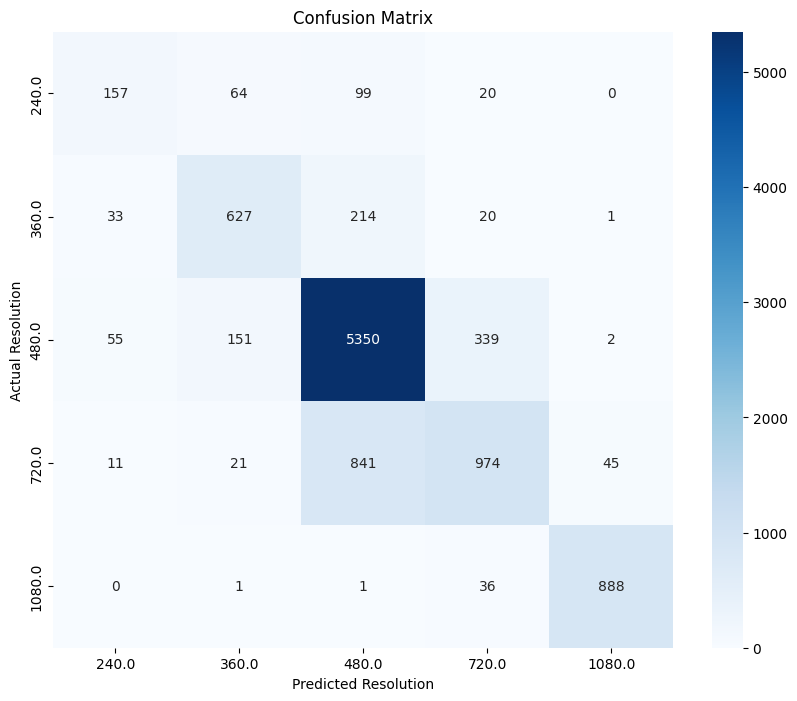


4. ROC/AUC Curves (One-vs-Rest):


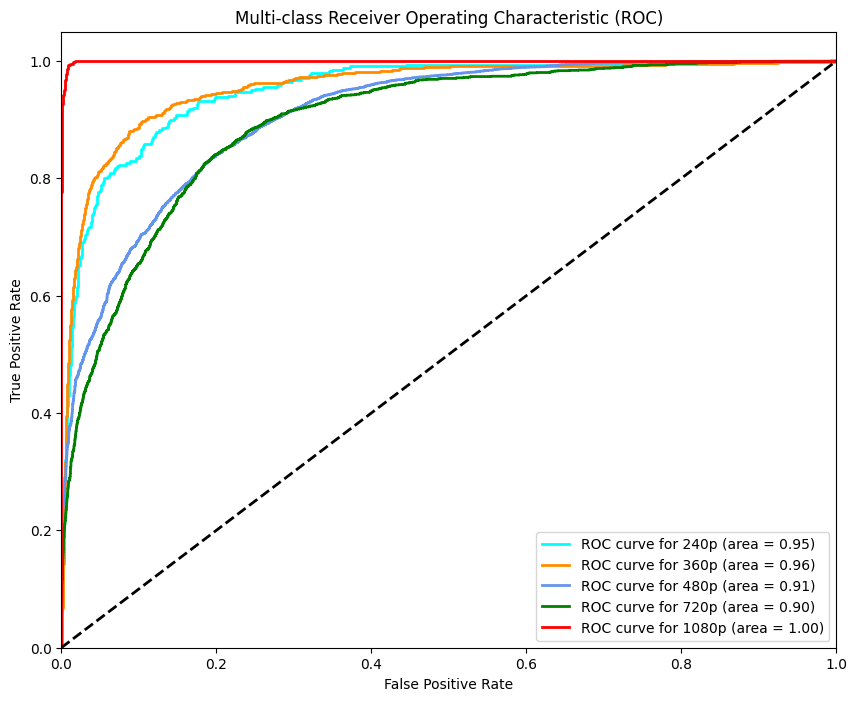

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

print("EVALUATING THE TUNED MODEL")

# 1. Get the best model from the grid search
best_model = grid_search.best_estimator_

# 2. Make predictions on the test data
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)

# 3. Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"1. Accuracy on Test Set: {accuracy:.4f}")

# 4. Calculate F1 Score
# Use 'weighted' to account for any class imbalance
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"2. Weighted F1 Score on Test Set: {f1:.4f}")

# Print a detailed classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=[str(int(r)) for r in sorted(y.unique())]))
print("---------------------------")

# 5. Generate and Plot Confusion Matrix
print("\n3. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.ylabel('Actual Resolution')
plt.xlabel('Predicted Resolution')
plt.show()

# 6. Calculate and Plot ROC/AUC for each class (One-vs-Rest)
print("\n4. ROC/AUC Curves (One-vs-Rest):")
# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=sorted(y.unique()))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0}p (area = {1:0.2f})'
             ''.format(int(sorted(y.unique())[i]), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

PREDICTING RESOLUTION FOR PART 2 TEST DATA

Predictions on the test set from Part 2:
        relative_timestamp  true_resolution  predicted_resolution
24866                 10.0            480.0                 480.0
164144                10.0            480.0                 480.0
78794                 10.0            720.0                 720.0
97530                 10.0           1080.0                1080.0
159571                10.0            720.0                 480.0


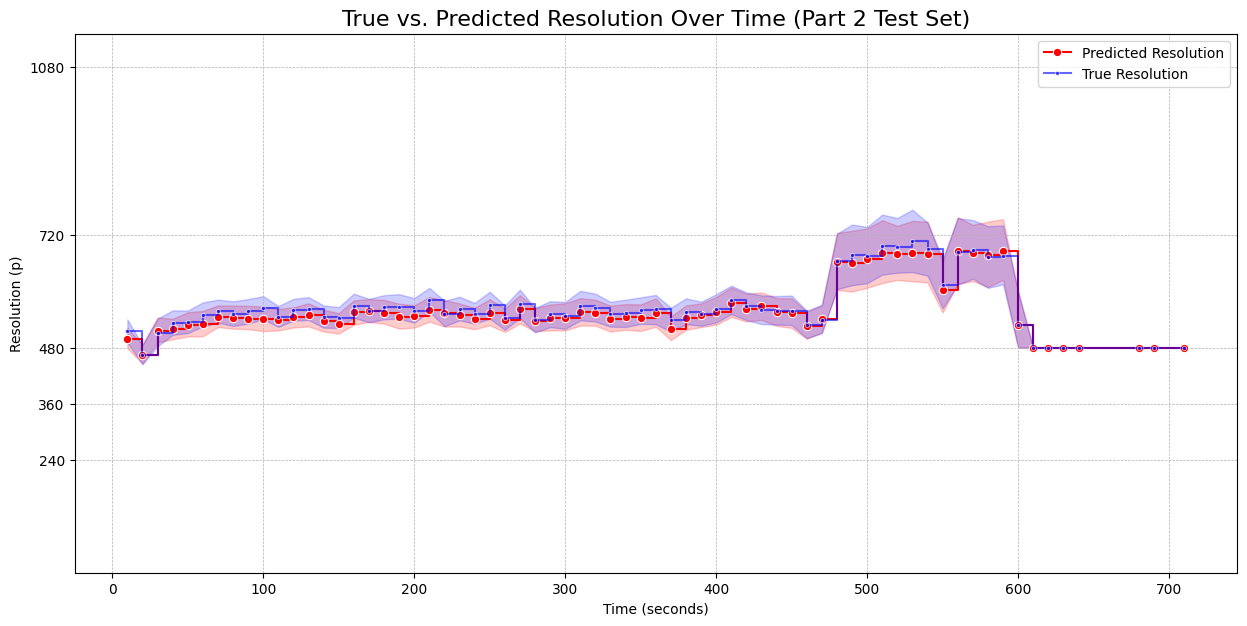

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("PREDICTING RESOLUTION FOR PART 2 TEST DATA")

# 1. Load the dataset.
video_df_with_time = pd.read_pickle('netflix_dataset.pkl')

# Create a DataFrame from the test data
test_df = X_test.copy()
test_df['relative_timestamp'] = video_df_with_time.loc[X_test.index, 'relative_timestamp']
test_df['true_resolution'] = y_test

# 2. The features for prediction are in X_test_scaled.
# The model is `best_model`.
predicted_resolutions = best_model.predict(X_test_scaled)
test_df['predicted_resolution'] = predicted_resolutions

# 3. Sort the DataFrame by timestamp to plot it chronologically.
test_df_sorted = test_df.sort_values('relative_timestamp')

print("\nPredictions on the test set from Part 2:")
print(test_df_sorted[['relative_timestamp', 'true_resolution', 'predicted_resolution']].head())

# 4. Plot the results
plt.figure(figsize=(15, 7))

# Plot predicted resolution
sns.lineplot(data=test_df_sorted, x='relative_timestamp', y='predicted_resolution', 
             marker='o', drawstyle='steps-post', label='Predicted Resolution', color='red')

# Plot actual resolution
sns.lineplot(data=test_df_sorted, x='relative_timestamp', y='true_resolution', 
             marker='.', drawstyle='steps-post', label='True Resolution', color='blue', alpha=0.6)

plt.title('True vs. Predicted Resolution Over Time (Part 2 Test Set)', fontsize=16)
plt.xlabel('Time (seconds)')
plt.ylabel('Resolution (p)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.yticks(sorted(y.unique()))
plt.ylim(0, 1150)
plt.show()
